# Reproduce GPT-2

Source: [Anderj Karpathy's Let's reproduce GPT-2(124M)](https://www.youtube.com/watch?v=l8pRSuU81PU&t=29s)

Using GPT-2 and GPT-3 papers.

We'll start from the end result - that is GPT2 model.
GPT2 implementation uses TensorFlow, we need a PyTorch implementation since it's the most used framework with other libraries. https://github.com/openai/gpt-2/blob/master/src/model.py

Huggingface has a pytorch implementation of GPT2, Let's load that model, explore the weights and do some sampling for text generation to understand our final objective.



In [1]:
from transformers import GPT2LMHeadModel

model_name = "gpt2" # 124M model
model_hf = GPT2LMHeadModel.from_pretrained(model_name)


/Users/jayaprakashsivagami/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sd_hf = model_hf.state_dict()
for layer_name, weights in sd_hf.items():
    print(layer_name, weights.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

1. transformer.wte.weight torch.Size([50257, 768])
2. transformer.wpe.weight torch.Size([1024, 768])

These two layers are embedding layer and position embedding layer.
The first layer shape is 50257(vocab size), 768(embedding dimension)
The second layer is position embedding, 1024(context size), 768(embedding dimension)

All the other layers are layers of the transformer model.

In [3]:
# Let's see some weights of embedding model
sd_hf["transformer.wpe.weight"].view(-1)[:30]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042,  0.0135, -0.0363,  0.0193, -0.0259,
         0.0080,  0.0085, -0.0199,  0.0668,  0.0071, -0.0266])

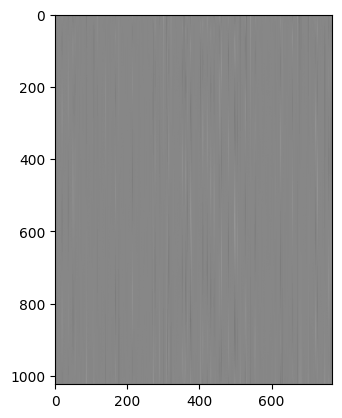

In [4]:
# Visualize position embeddings
import matplotlib.pyplot as plt
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="grey")

Each row in this visualization is an absolute position out of the context length of 1024 across 768 dimensons.

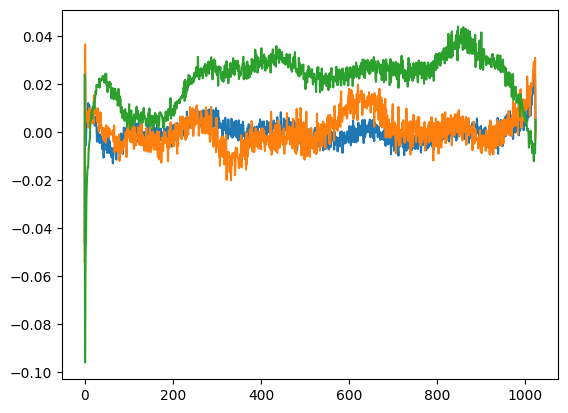

In [9]:
# Let's visualize individual channels from above
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])
plt.plot(sd_hf['transformer.wpe.weight'][:, 200])
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])


We can see each channel is active for particular context size.
In original transformers paper position embedding were intialized to sinusoids and cosines, in GPT2 they're intialized and trained to scratch but they recover the sins and cosines. This is the reason for the structure in the position embedding visualization.

torch.Size([768, 2304])


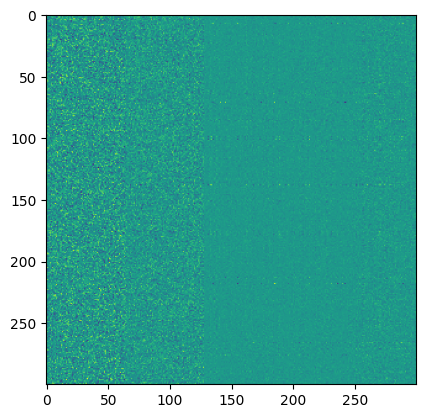

In [13]:
print(sd_hf["transformer.h.1.attn.c_attn.weight"].shape)
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300])

In [14]:
# Let's do some sampling
from transformers import pipeline, set_seed
generator = pipeline("text-generation", "gpt2")
set_seed(42)
generator("You're an language model", max_length=30, num_workers=2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "You're an language model: what you do in that role is different—how you say sentences in a language model, and how you do what people"}]

We're gonna try to replicate the above architecture, load the weights and generate some coherent text.

How GPT2 varies from original attention paper, The normalization layer are moved before multi-attention head blocks and final attention layer is added before computation layer.

## Recreating GPT2 Skeleton based on above state_dicts

Once this is created, we'll use this instead of hf model. We'll recreate MultiHeadedAttention in NanoGpt but in much more effecient manner.

We've to recreate the below:
1. embedding layer.
2. positional embedding.
3. ModuleList of SelfAttetion + Computation Blocks.
4. Self attention and computation blocks will be created seperatley.
5. We'll follow the same naming convention of sd_hf in all the layers to make weight loading easier.

In [1]:
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass

@dataclass
class GPTConfig:
    """
    Config class to hold hyperparmeters of the model
    """
    block_size = 1024 # max sequence lenth
    vocab_size = 50257 # Number of tokens: 256 byte tokens + 1 <|endoftext|> token + 50,000 BPE merges
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dim

class CasualSelfAttention(nn.Module):
    """_summary_
    Attention block - where all relationships between tokens are learned

    Implement the same multi headed attention logic as nangpt but in much efficient manner
    Implements accepting a batch of inputs
    Calculates query-key-vectors
    Calculates attention scores
    Calculate scaled dot product attention to calculate attention weights - the tril value etc in nanogpt implementation
    Concatenate all attention weights

    Requires:
    1. key,query,value vectors
    2. Linear layer to return to embed, embed dimension to be passed to MLP block

    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        # Ensure embedding dim is divisible by n_head to avoid errors
        assert self.config.n_embd % self.config.n_head == 0
        # 3 * -> instead of initalizing three seperate Linear layers, we'll split this later in forward pass
        self.c_attn = nn.Linear(self.config.n_embd, 3 * self.config.n_embd)
        # Output projection
        self.c_proj = nn.Linear(self.config.n_embd, self.config.n_embd)

    def forward(self, x):
        """_summary_

        Accepts input tensor, performs attention mechanism batchwise, returns projected output
        """

        B, T, C = x.size() # batch size, sequence length, embedding dimension(n_embd)
        # Calculate query, key, values for all heads in batch(using torch.view()) and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C(number of channels) = nh*ns or C/n_head = head_size
        # GPT-2(124M), n_heads=12, hs=64, so nh*ns=C=768 channels in the Transformer
        
        # 1. querykeyvalue vector
        qkv = self.c_attn(x)
        # 2. Split this into query, key, value using torch.split(), shape of c_attn(B, n_embd, 3*n_embd), split along 2nd dim
        # to get q,k,v of shape (B, n_embd, n_embd)
        q, k, v = qkv.split(self.n_embd, dim=2)
        # 3. Multi Headed Attention
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        # 4. Scaled dor product, the reshaping above is for this
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # Flash attention
        # 5. ReTranspose(B, T nh, ns), contiguous for memory efficiency, return to original shape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # 6. Output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    """_summary_
    Computation block after attention block

    In two linear layers between activation we increase the computation
    by 4*embedding dimension. The 4 comes from sd_hf transformer.h.11.mlp.c_fc.weight torch.Size([768, 3072])
    3072 /4 = 768

    We use GELU, due to it's smoothness(Send a small until a certain limit in x-axis for negative values and then sends zero)
    This smoothening reduces vanishing gradients
    To replicate GPT2 paper approximate implementation of GELU from pytorch is used. This is no longer needed
    
    map in map-reduce

    Requires:
    1. Two Linear layers
    2. GELU activation
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        # Layers
        self.c_fc = nn.Linear(self.config.n_embd, 4*self.config.n_embd)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*self.config.n_embd, self.config.n_embd)

    def forward(self, x):
        """
        Forward function call to implement the computation after attentino block
        """
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    """_summary_

    Block of attention plus computation

    Requires:
    1. Two normalization layer for pre-normalization with attention and computation(mlp)
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.ln_1 = nn.LayerNorm(self.config.n_embd)
        self.attn = CasualSelfAttention(self.config)
        self.ln_2 = nn.LayerNorm(self.config.n_embd)
        self.mlp = MLP(self.config)

    def forward(self, x):
        """_summary_
        1. Accepts input
        2. Implements Normalization -> Casual Attentation + Residual Connection
        3. Implemennts Normalization -> MLP + Residual connection
        """
        # Input is normalized, attention, then residual connection is created
        # Remember addition just sends the gradient to both it's connections
        # A clean gradient goes  through residual connection and attention normalization block alters the gradient accordingly
        # Attention mechanism - tokens interact with each other, can be assumed like reduce
        x = x + self.attn(self.ln_1(x))
        # Computation mechanism - each tokens are computed individually, can be assumed like map
        x = x + self.MLP(self.ln_2(x))
        return x


class GPT2(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # config to access parameters
        self.config = config

        # Layers of the model to be called in forward function implementation
        # transformers naming convention from sd_hf
        self.transformers = nn.ModuleDict(dict(
            # wte naming convention from sd_hf, Token Embeddings
            wte = nn.Embedding(self.config.vocab_size, self.config.n_embd),
            # Position embeddings
            wpe = nn.Embedding(self.config.block_size, self.config.n_embd),
            # construct the module list h.0, h.1...,h.11 in st_hf
            h = nn.ModuleList([Block(self.config) for _ in range(self.config.n_layer)]),
            # final layer normalization
            ln_f = nn.LayerNorm(self.config.n_embd)
        ))
        self.lm_head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)



In [2]:
config = GPTConfig()
model = GPT2(config)

In [5]:
list(model.state_dict().keys())

['transformers.wte.weight',
 'transformers.wpe.weight',
 'transformers.h.0.ln_1.weight',
 'transformers.h.0.ln_1.bias',
 'transformers.h.0.attn.c_attn.weight',
 'transformers.h.0.attn.c_attn.bias',
 'transformers.h.0.attn.c_proj.weight',
 'transformers.h.0.attn.c_proj.bias',
 'transformers.h.0.ln_2.weight',
 'transformers.h.0.ln_2.bias',
 'transformers.h.0.mlp.c_fc.weight',
 'transformers.h.0.mlp.c_fc.bias',
 'transformers.h.0.mlp.c_proj.weight',
 'transformers.h.0.mlp.c_proj.bias',
 'transformers.h.1.ln_1.weight',
 'transformers.h.1.ln_1.bias',
 'transformers.h.1.attn.c_attn.weight',
 'transformers.h.1.attn.c_attn.bias',
 'transformers.h.1.attn.c_proj.weight',
 'transformers.h.1.attn.c_proj.bias',
 'transformers.h.1.ln_2.weight',
 'transformers.h.1.ln_2.bias',
 'transformers.h.1.mlp.c_fc.weight',
 'transformers.h.1.mlp.c_fc.bias',
 'transformers.h.1.mlp.c_proj.weight',
 'transformers.h.1.mlp.c_proj.bias',
 'transformers.h.2.ln_1.weight',
 'transformers.h.2.ln_1.bias',
 'transformers.h

Next, we'll implement a from_pretrained() classmethod to load weights from huggingface to our GPT model.
1. Align keys(layer names)
2. ignore bias layers
3. Transpose original GPT2 CNN weights to fit into Linear layers of our implementation.

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
from transformers import GPT2LMHeadModel

@dataclass
class GPTConfig:
    """
    Config class to hold hyperparmeters of the model
    """
    block_size: int = 1024 # max sequence lenth
    vocab_size: int = 50257 # Number of tokens: 256 byte tokens + 1 <|endoftext|> token + 50,000 BPE merges
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dim

class CasualSelfAttention(nn.Module):
    """_summary_
    Attention block - where all relationships between tokens are learned

    Implement the same multi headed attention logic as nangpt but in much efficient manner
    Implements accepting a batch of inputs
    Calculates query-key-vectors
    Calculates attention scores
    Calculate scaled dot product attention to calculate attention weights - the tril value etc in nanogpt implementation
    Concatenate all attention weights

    Requires:
    1. key,query,value vectors
    2. Linear layer to return to embed, embed dimension to be passed to MLP block

    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        # Ensure embedding dim is divisible by n_head to avoid errors
        assert self.config.n_embd % self.config.n_head == 0
        # 3 * -> instead of initalizing three seperate Linear layers, we'll split this later in forward pass
        self.c_attn = nn.Linear(self.config.n_embd, 3 * self.config.n_embd)
        # Output projection
        self.c_proj = nn.Linear(self.config.n_embd, self.config.n_embd)

    def forward(self, x):
        """_summary_

        Accepts input tensor, performs attention mechanism batchwise, returns projected output
        """

        B, T, C = x.size() # batch size, sequence length, embedding dimension(n_embd)
        # Calculate query, key, values for all heads in batch(using torch.view()) and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C(number of channels) = nh*ns or C/n_head = head_size
        # GPT-2(124M), n_heads=12, hs=64, so nh*ns=C=768 channels in the Transformer
        
        # 1. querykeyvalue vector
        qkv = self.c_attn(x)
        # 2. Split this into query, key, value using torch.split(), shape of c_attn(B, n_embd, 3*n_embd), split along 2nd dim
        # to get q,k,v of shape (B, n_embd, n_embd)
        q, k, v = qkv.split(self.n_embd, dim=2)
        # 3. Multi Headed Attention
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) -> (B, nh, T, ns)
        # 4. Scaled dor product, the reshaping above is for this
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # Flash attention
        # 5. ReTranspose(B, T nh, ns), contiguous for memory efficiency, return to original shape
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        # 6. Output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    """_summary_
    Computation block after attention block

    In two linear layers between activation we increase the computation
    by 4*embedding dimension. The 4 comes from sd_hf transformer.h.11.mlp.c_fc.weight torch.Size([768, 3072])
    3072 /4 = 768

    We use GELU, due to it's smoothness(Send a small until a certain limit in x-axis for negative values and then sends zero)
    This smoothening reduces vanishing gradients
    To replicate GPT2 paper approximate implementation of GELU from pytorch is used. This is no longer needed
    
    map in map-reduce

    Requires:
    1. Two Linear layers
    2. GELU activation
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        # Layers
        self.c_fc = nn.Linear(self.config.n_embd, 4*self.config.n_embd)
        self.gelu = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*self.config.n_embd, self.config.n_embd)

    def forward(self, x):
        """
        Forward function call to implement the computation after attentino block
        """
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    """_summary_

    Block of attention plus computation

    Requires:
    1. Two normalization layer for pre-normalization with attention and computation(mlp)
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.ln_1 = nn.LayerNorm(self.config.n_embd)
        self.attn = CasualSelfAttention(self.config)
        self.ln_2 = nn.LayerNorm(self.config.n_embd)
        self.mlp = MLP(self.config)

    def forward(self, x):
        """_summary_
        1. Accepts input
        2. Implements Normalization -> Casual Attentation + Residual Connection
        3. Implemennts Normalization -> MLP + Residual connection
        """
        # Input is normalized, attention, then residual connection is created
        # Remember addition just sends the gradient to both it's connections
        # A clean gradient goes  through residual connection and attention normalization block alters the gradient accordingly
        # Attention mechanism - tokens interact with each other, can be assumed like reduce
        x = x + self.attn(self.ln_1(x))
        # Computation mechanism - each tokens are computed individually, can be assumed like map
        x = x + self.MLP(self.ln_2(x))
        return x


class GPT2(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # config to access parameters
        self.config = config

        # Layers of the model to be called in forward function implementation
        # transformers naming convention from sd_hf
        self.transformers = nn.ModuleDict(dict(
            # wte naming convention from sd_hf, Token Embeddings
            wte = nn.Embedding(self.config.vocab_size, self.config.n_embd),
            # Position embeddings
            wpe = nn.Embedding(self.config.block_size, self.config.n_embd),
            # construct the module list h.0, h.1...,h.11 in st_hf
            h = nn.ModuleList([Block(self.config) for _ in range(self.config.n_layer)]),
            # final layer normalization
            ln_f = nn.LayerNorm(self.config.n_embd)
        ))
        self.lm_head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)

    @classmethod
    def from_pretrained(cls, model_type):
        """_summary_

        Loads pretrained weights from huggingface

        1. Defines neural network parameters
        2. Load Local implementation model and hf model
        3. Load both state dicts, align keys and copy the weigts

        Args:
            model_type (str): gpt2 model types froem hugging face

        """

        assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}
        print("Loading weights from pretrained gpt: %s" % model_type)

        # Define layer parameters for gpt series models and select
        config_args = {
            "gpt2":         dict(n_layer=12, n_head=12, n_embd=12), # 124M params
            "gpt2-medium":  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params        
        }[model_type]
        
        # Below params are same for all GPT2 variants
        config_args["vocab_size"] = 50257
        config_args["block_size"] = 1024

        print(config_args)
        # Create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        print(f"config: {config}")
        model = GPT2(config)

        # Get keys, # memory map sd_keys -> sd -> model the key copy is present inplace
        sd = model.state_dict()
        sd_keys = sd.keys()
        # remove bias keys
        sd_keys = [k for k in sd_keys if not k.endswith(".attn.bias")]

        # Load huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        # Get keys
        sd_hf = model_hf.state_dict()
        sd_hf_keys = sd_hf.keys()
        # Remove bias
        sd_hf_keys = [k for k in sd_hf_keys if not k.endswith(".attn.bias")]
        sd_hf_keys = [k for k in sd_hf_keys if not k.endswith(".attn.masked_bias")]
        # Four keys (attn.c_attn - Attnetion linear layers), (attn.c_proj - output linear projection of attention layer)
        # (mlp.c_fc, mlp.c_proj - MLP computation)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        assert len(sd_hf_keys) == len(sd_keys), f"Mismatched kyes: {len(sd_hf_keys)} != {len(sd_keys)}"

        for k in sd_hf_keys:
            if any(k.endswith(w) for w in transposed):
                # Check shapes, transpose fits Conv1D wieghts to a Linear layer
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    # Copy transposed weights from hf to scratch
                    sd[k].copy_(sd_hf[k].t())
            else:
                # Match shape and vanilla copy over the other params
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [6]:
# This is implemented in gpt2.py let's test this
from gpt2 import GPT2, GPTConfig
config = GPTConfig()
model = GPT2(config)

In [13]:
list(model.state_dict().keys())

['transformers.wte.weight',
 'transformers.wpe.weight',
 'transformers.h.0.ln_1.weight',
 'transformers.h.0.ln_1.bias',
 'transformers.h.0.attn.c_attn.weight',
 'transformers.h.0.attn.c_attn.bias',
 'transformers.h.0.attn.c_proj.weight',
 'transformers.h.0.attn.c_proj.bias',
 'transformers.h.0.ln_2.weight',
 'transformers.h.0.ln_2.bias',
 'transformers.h.0.mlp.c_fc.weight',
 'transformers.h.0.mlp.c_fc.bias',
 'transformers.h.0.mlp.c_proj.weight',
 'transformers.h.0.mlp.c_proj.bias',
 'transformers.h.1.ln_1.weight',
 'transformers.h.1.ln_1.bias',
 'transformers.h.1.attn.c_attn.weight',
 'transformers.h.1.attn.c_attn.bias',
 'transformers.h.1.attn.c_proj.weight',
 'transformers.h.1.attn.c_proj.bias',
 'transformers.h.1.ln_2.weight',
 'transformers.h.1.ln_2.bias',
 'transformers.h.1.mlp.c_fc.weight',
 'transformers.h.1.mlp.c_fc.bias',
 'transformers.h.1.mlp.c_proj.weight',
 'transformers.h.1.mlp.c_proj.bias',
 'transformers.h.2.ln_1.weight',
 'transformers.h.2.ln_1.bias',
 'transformers.h

In [15]:
model_hf.state_dict().keys()

odict_keys(['transformer.wte.weight', 'transformer.wpe.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.h.2.ln_1.weight', 'transformer.h.2.ln_1.bias', 'transformer.h.2.attn.c_attn.weight', 'transformer.h.2.attn.

In [17]:
import torch
torch.arange(0, 10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

The weights are loaded... Let's do sampling to generate tokens. To do that let's implement the forward pass.

forward():
1. Requires, idx(input tokens in batches)
2. targets(optional) labels
3. Create positional embeddings, token embeddings, pass through block list, get logits from lm_head
4. Calculate loss if targets is not None
4. Return logits and loss

Additional points:
* Positional embeddings, token embedding broadcast.
* Logits will be reshaped to match targets to calculae loss, preserve embedding/channel dimension and concatenate tokens along batch.

In [13]:
# Logits reshape
import torch
idx = torch.ones(8, 16, 768)
print(f"Original shape: {idx.shape}")
print(idx.view(-1, idx.size(-1)).shape)
print(f"Product of first two dimensions: {8 * 16}")

Original shape: torch.Size([8, 16, 768])
torch.Size([128, 768])
Product of first two dimensions: 128


## Sampling Tokens

We'll see the generation in huggingface and replicate it with our scratch model.

In [2]:
# Sampling with hf
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline(task="text-generation", model="gpt2")
pipe("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

Sampling loop is implemented in sample.py file. Let's import that to run it's code and compare the output.

In [1]:
import sample

/Users/jayaprakashsivagami/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading weights from pretrained gpt: gpt2
Tokens shape after repeat: torch.Size([5, 8])
Sequence shape after geneartion: torch.Size([5, 30])
Sequence No: 0
> Hello, I'm a language model, not a programming platform! I just make decisions based on other projects. I try to do that."


Sequence No: 1
> Hello, I'm a language model, a kind of a "first class citizen" of the world and a person that comes from a much more egalitarian
Sequence No: 2
> Hello, I'm a language model, and I'm starting to talk about the notion of the syntax, and I'm also working on an extension that
Sequence No: 3
> Hello, I'm a language model, because I'm writing real-time. I'm writing all languages. And I'm working with languages for me
Sequence No: 4
> Hello, I'm a language model, I don't know where to begin but I know there is a big deal going on with our society. What


There's difference in generations, let's try with GPT2 Model instead of pipeline and see the generations. Updated the model and logits lines.

In [1]:
import sample

/Users/jayaprakashsivagami/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokens shape after repeat: torch.Size([5, 8])
Sequence shape after geneartion: torch.Size([5, 30])
Sequence No: 0
> Hello, I'm a language model, not a programming platform! I just make decisions based on other projects. I try to do that."


Sequence No: 1
> Hello, I'm a language model, a kind of a "first class citizen" of the world and a person that comes from a much more egalitarian
Sequence No: 2
> Hello, I'm a language model, and I'm starting to talk about the notion of the syntax, and I'm also working on an extension that
Sequence No: 3
> Hello, I'm a language model, because I'm writing real-time. I'm writing all languages. And I'm working with languages for me
Sequence No: 4
> Hello, I'm a language model, I don't know where to begin but I know there is a big deal going on with our society. What


The sampling results are same for models but pipeline differes. There might be additional details in pipeline logic probabaly. But the model loading is good.

## Preparing dataset

Now we've sampled some data using GPTScratch and GPTHf models and verfied the generation is same. Next steps is to move on to the objective of training our Scratch model to match this generation.

Let's perform a minimalistic training before scaling up with more data and GPU. Tiny Shakespearan dataset from character RNN and nanoGPT is gonna be the dataset.

input.txt --> dataset.

In [2]:
!ls -lrt input.txt

-rw-r--r--  1 jayaprakashsivagami  staff  1115394 Aug 28 07:38 input.txt


In [3]:
!ls -lsrht input.txt

2184 -rw-r--r--  1 jayaprakashsivagami  staff   1.1M Aug 28 07:38 input.txt


In [4]:
!wc input.txt

   40000  202651 1115394 input.txt


Dataset has:

* 40k lines
* 202k words
* 1M ascii characters (1byte per ascii character, assuming no unicode characters in the dataset.)

How do we prepare the dataset for next token prediction objective:

1. Encode the text with tiktoken
2. Get B*T + 1(target token) from dataset. Additional final token is for dataset creation.
    * tokens[-1].view(B, T) -> input tokens. Leave final token for target
    * tokens[1:].view(B, T) -> output tokens. Leave first token as it can't be predicted as target
3. x, y have the same shape

In [5]:
with open("input.txt", "r") as file:
    data = file.read()

In [10]:
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [14]:
import torch
import tiktoken
encoder = tiktoken.get_encoding("gpt2")
tokens = encoder.encode(data[:1000])

In [19]:
# Let's create batch size of 8 with 32 tokens in a single sequence
# B, T -> (8, 32) -> 8*32(256) tokens needed

B = 8
T = 32

# Get B*T + 1(target token) from dataset. Additional final token is for dataset creation.
buf = torch.tensor(tokens[:B*T + 1])
# tokens[-1].view(B, T) -> input tokens. Leave final token for target
x = buf[:-1].view(8, 32)
# tokens[1:].view(B, T) -> output tokens. Leave first token as it can't be predicted as target
y = buf[1:].view(8, 32)
# view here takes 256 tokens cuts them by T and arranges them vertically in a size of B.
# order of tokens are preserved with this view

In [21]:
x[1, :], y[1, :]

(tensor([  477, 12939,  2138,   284,  4656,   621,   284,  1145,   680,    30,
           198,   198,  3237,    25,   198,  4965,  5634,    13, 12939,    13,
           198,   198,  5962, 22307,    25,   198,  5962,    11,   345,   760,
           327,  1872]),
 tensor([12939,  2138,   284,  4656,   621,   284,  1145,   680,    30,   198,
           198,  3237,    25,   198,  4965,  5634,    13, 12939,    13,   198,
           198,  5962, 22307,    25,   198,  5962,    11,   345,   760,   327,
          1872,   385]))

The above logic's been put into data.py. train.py also been created to calculate loss and logits.

With this we can take our scratch model without weights from huggingFace for a run. The CrossEntropyLoss should be around -ln(1/50257) = 10.824. The math is a fancy way of saying the model should have the same probability for all tokens in the vocab size(50257) after intialization. This is the negative log likelihood explored in nanoGPT repo as well.

## Training

### Initial loss

In [22]:
import torch
from gpt2 import GPT2, GPTConfig
from data import create_data

# Setup device agnostic
device = "cpu" 
if torch.cuda.is_available():
    device = "cuda"    
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"

print(f"Using device: {device}")

model = GPT2(GPTConfig)
model.to(device)
x, y = create_data(B=4, T=32)
logits, loss = model(x, y)

print(loss)

/Users/jayaprakashsivagami/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokens size: torch.Size([257])
Shape of x and y: torch.Size([8, 32]), torch.Size([8, 32])
Using device: cpu
Tokens size: torch.Size([129])
Shape of x and y: torch.Size([4, 32]), torch.Size([4, 32])
tensor(11.0533, grad_fn=<NllLossBackward0>)


The loss is nearly close to expected log likelihood.

### Single Batch Overfit

To get the below losses, run `train.py` with `SINGLE_BATCH_OVERFIT=True`. I've copied the losses from final print statement.

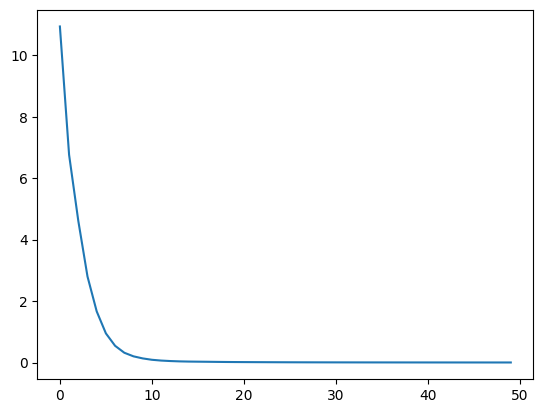

In [5]:
import matplotlib.pyplot as plt
import numpy as np
losses = [10.934867858886719, 6.75793981552124, 4.611110687255859, 2.799591064453125, 1.665027379989624, 0.9489315152168274, 0.5449665784835815, 0.3196530342102051, 0.2023976445198059, 0.1351081132888794, 0.09048067033290863, 0.06494414806365967, 0.04946185648441315, 0.03861209750175476, 0.03229759633541107, 0.028889095410704613, 0.02569054439663887, 0.022067926824092865, 0.01895262487232685, 0.016752731055021286, 0.015179792419075966, 0.01386350765824318, 0.012592772021889687, 0.011343221180140972, 0.010186911560595036, 0.009179782122373581, 0.00832995306700468, 0.007621534168720245, 0.007029481697827578, 0.006530685815960169, 0.006104296538978815, 0.0057342941872775555, 0.005408747121691704, 0.005118152126669884, 0.004856342449784279, 0.004618883598595858, 0.004402546212077141, 0.00420440873131156, 0.0040231728926301, 0.003857098985463381, 0.003704558126628399, 0.0035645689349621534, 0.003436112543568015, 0.003317768918350339, 0.0032084325794130564, 0.0031078001484274864, 0.0030145253986120224, 0.002927956869825721, 0.00284748082049191, 0.0027726672124117613]
plt.plot(np.arange(0, len(losses)), losses)
plt.savefig("single-batch-overfit-losses.png")

With this loss progression, we can see the loss is crunched really fast. The transformer has memorized/overfitted on this single batch. This is good. :)

Next, we'll write a DataLoader to feed new batches of data to the model for training. This'll be written in data.py 
`class DataLoaderLite`

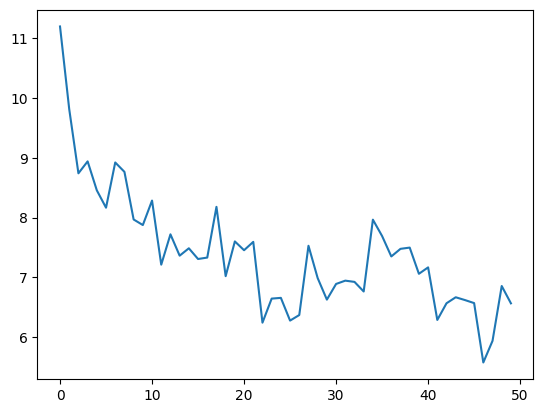

In [12]:
losses = [11.19256591796875, 9.811361312866211, 8.739070892333984, 8.938462257385254, 8.45466136932373, 8.164630889892578, 8.920323371887207, 8.763519287109375, 7.967740535736084, 7.874715805053711, 8.283684730529785, 7.212910175323486, 7.7196455001831055, 7.362977027893066, 7.486379623413086, 7.307404041290283, 7.331233501434326, 8.178604125976562, 7.020561218261719, 7.60125732421875, 7.454036712646484, 7.593718528747559, 6.243679046630859, 6.645630359649658, 6.657945156097412, 6.278136253356934, 6.3712873458862305, 7.528584957122803, 6.98809289932251, 6.628602504730225, 6.890379905700684, 6.945662498474121, 6.924927711486816, 6.764522552490234, 7.964726448059082, 7.691166877746582, 7.35003137588501, 7.477172374725342, 7.4979071617126465, 7.059983730316162, 7.167243003845215, 6.289151191711426, 6.567668437957764, 6.668101787567139, 6.621483325958252, 6.57069206237793, 5.578410625457764, 5.939566612243652, 6.856008529663086, 6.566385746002197]
plt.plot(np.arange(0, len(losses)), losses)
plt.savefig("50-batch-overfit-losses.png")

Inferences from output:
1. Number of tokens: 338025 # Compression ratio of 3:1 matches
2. Total number of batches per epoch: 2640

Here, we can see the loss reduction is not as fast as single batch overfit but still the loss is decreasing...
The plot seems noisy but the loss curve looks good.
Here the gains are mainly from crunching the logits for unicode characters in the vocab to negative infinity. PS: no unicode characters in the dataset.


## Model update - Parameter sharing

Let's explore the parameter exploration in attention is all you need paper. [Section 3.5 Embeddings and Softamx paper covers this](https://arxiv.org/pdf/1706.03762), output embedding and final lineary layer shares the same shape. Let's explore this in huggingface model.

In [14]:
sd_hf["transformer.wte.weight"].size(), sd_hf["lm_head.weight"].size()

(torch.Size([50257, 768]), torch.Size([50257, 768]))

The shapes are same for the token embedding layer and lm_head(calculates logits for 50257 tokens from 768 dimension).

In [15]:
(sd_hf["transformer.wte.weight"] == sd_hf["lm_head.weight"]).all()

tensor(True)

In [18]:
# Let's print the pointer of weights
print(sd_hf["transformer.wte.weight"].data_ptr())
print(sd_hf["lm_head.weight"].data_ptr())

6507495379
6507495379


Even the pointer are same.

Comparison of each individual weight is also the same. The reasoning behind this is from [paper 30](https://arxiv.org/pdf/1608.05859) referred in attention is all you need.

*We call U the input embedding, and V the output embedding. In both matrices, we expect rows that correspond to similar words to be sim- ilar: for the input embedding, we would like the network to react similarly to synonyms, while in the output embedding, we would like the scores of words that are interchangeable to be similar (Mnih and Teh, 2012).*

Thinking intutivley as well the above statement makes sense. 

* Similar word embeddings are closer in embedding dimension plane.
* Similar words have similar scores in final layer before softmax.

We'll use the pointer method to share weights between two layers:
`embedding_layer = lm_head_layer`

Major advantge is reduction of parameters, with 50527 * 768 = 39M Parameters roughly 40M. This is 1/4th of a 124M parameter GPT model. We've saved lot's of parameters as well.

Let's visualize the losses to see if there's any improvement.

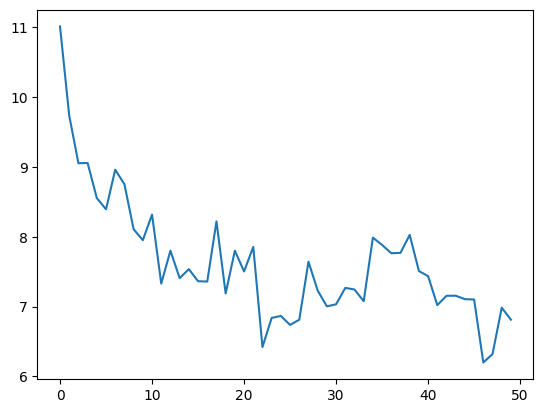

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
losses = [11.011063575744629, 9.734055519104004, 9.0523042678833, 9.055379867553711, 8.552644729614258, 8.392791748046875, 8.959522247314453, 8.750679969787598, 8.106810569763184, 7.9503560066223145, 8.316915512084961, 7.328124523162842, 7.799679279327393, 7.4068098068237305, 7.534953594207764, 7.3624396324157715, 7.357262134552002, 8.219290733337402, 7.187446594238281, 7.799190044403076, 7.502461910247803, 7.8540754318237305, 6.419301509857178, 6.836949825286865, 6.864908695220947, 6.73622989654541, 6.810690879821777, 7.642209529876709, 7.2282395362854, 7.002841949462891, 7.0315070152282715, 7.266716480255127, 7.2437567710876465, 7.075949668884277, 7.986493110656738, 7.881979942321777, 7.762958526611328, 7.768392562866211, 8.025918960571289, 7.508533954620361, 7.435084342956543, 7.01965856552124, 7.153522968292236, 7.154743671417236, 7.105139255523682, 7.100391387939453, 6.198450088500977, 6.318370342254639, 6.982813358306885, 6.811880111694336]
plt.plot(np.arange(0, len(losses)), losses)
plt.savefig("50-batch-overfit-losses-param-sharing.png")

## Model Initilization

Let's intialize the model more inline with GPT2. Initialization is more explicit in openai code for gtp2.py than paper.

In [code](https://github.com/openai/gpt-2/blob/master/src/model.py):
* model() function initialized wpe and wte to random normal distributions with std 0.01 and 0.02 respectivley.
* conv1d()(linear layer in our case) has std of 0.02.
* This 0.02 stands inline with xavier intialization which is 1/sqrt(number of incoming features)
* The number of incoming features for wpe, wte and linear layers are emedding dimension of different gpt variants.
* The different embedding dimensions are [768, 1024, 1280, 1600]


In [34]:
# Verifying that input features of all linear layers are embedding dimension size
for layer, weights in sd_hf.items():
    if "ln" in layer:
        print(f"Layer name: {layer}")
        print(f"Shape:{weights.size()}")

Layer name: transformer.h.0.ln_1.weight
Shape:torch.Size([768])
Layer name: transformer.h.0.ln_1.bias
Shape:torch.Size([768])
Layer name: transformer.h.0.ln_2.weight
Shape:torch.Size([768])
Layer name: transformer.h.0.ln_2.bias
Shape:torch.Size([768])
Layer name: transformer.h.1.ln_1.weight
Shape:torch.Size([768])
Layer name: transformer.h.1.ln_1.bias
Shape:torch.Size([768])
Layer name: transformer.h.1.ln_2.weight
Shape:torch.Size([768])
Layer name: transformer.h.1.ln_2.bias
Shape:torch.Size([768])
Layer name: transformer.h.2.ln_1.weight
Shape:torch.Size([768])
Layer name: transformer.h.2.ln_1.bias
Shape:torch.Size([768])
Layer name: transformer.h.2.ln_2.weight
Shape:torch.Size([768])
Layer name: transformer.h.2.ln_2.bias
Shape:torch.Size([768])
Layer name: transformer.h.3.ln_1.weight
Shape:torch.Size([768])
Layer name: transformer.h.3.ln_1.bias
Shape:torch.Size([768])
Layer name: transformer.h.3.ln_2.weight
Shape:torch.Size([768])
Layer name: transformer.h.3.ln_2.bias
Shape:torch.Size

In [25]:
gpt2_dimension_sizes = [768, 1024,1280, 1600]
xavier_inits = []
for dim in gpt2_dimension_sizes:
    print(f"dimension: {dim}")
    print(f"xavier init: {dim ** -0.5}")
    xavier_inits.append(dim ** -0.5)
print(f"Mean of inits: {np.mean(xavier_inits)}")
print(f"Median of inits: {np.median(xavier_inits)}")


dimension: 768
xavier init: 0.03608439182435161
dimension: 1024
xavier init: 0.03125
dimension: 1280
xavier init: 0.02795084971874737
dimension: 1600
xavier init: 0.025
Mean of inits: 0.030071310385774742
Median of inits: 0.029600424859373684


It looks like median of xavier init was used for intialization of weights.

This is implemented in gpt2.py using below method and executed using self.apply in the constructor over this method.

In [37]:
def _init_weights(self):
        # Loop through moduels of self.transformer and if they are nn.Linear or nn.Embedding set std to 0.02
        for module in self.modules():
            # This is xavier init median of vocab_size of different variants of GPT2. Refer notebook for more details
            std = 0.02
            if isinstance(module, nn.Linear):
                # initialize module.weight(tensor in place) to normal distribution with mean 0 and std 0.02.
                # normal_ underscore at the end performs inplace intialization to the tensor
                torch.nn.init.normal_(module.weight, mean=0.0, std=std)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            if isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0.0, std=std)

One more initlization left for residual connection. Residual connection in `Block`. In forward pass, the standard deviation of activations increases. To control this below's the excerpt from GPT2 paper:

***A modified initialization which accounts for the accumulation on the residual path with model depth is used. We scale the weights of residual layers at intialization by a factor of 1/ sqrt(N) where N is the number of residual layers.***

In [41]:
import torch
x = torch.zeros(768)
for i in range(50):
    x += torch.randn(768)

print(x.std())

tensor(7.2193)


In [45]:
import torch
x = torch.zeros(768)
n = 50 # number of layers
for i in range(50):
    x += n**-0.5 * torch.randn(768)

print(x.std())

tensor(0.9861)


The mean is now standardized to 1.

How do we apply to this to GPT2 skeleton. This is followed by two c_proj in MLP and CasualAttentionLayer.

Now we've successfully created GPT2 model from OpenAI Paper.

In [1]:
import torch

In [2]:
torch.tril(
    torch.ones(4, 4)
)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [19]:
mask = torch.tril(
    torch.ones(30, 30)
).view(1,1,30,30)

In [4]:
b = torch.ones((8,12,30,64))

In [9]:
o = b @ b.transpose(-2,-1)

In [11]:
o.size()

torch.Size([8, 12, 30, 30])

In [18]:
o.masked_fill(mask == 0, float("-inf"))

RuntimeError: The size of tensor a (64) must match the size of tensor b (30) at non-singleton dimension 3